## Preprocessing Data

In [2]:
import numpy as np
from PIL import Image
import os

def load_and_extract_features(image_dir, labels_df):
    features_list = []
    valid_indices = []
    
    for idx, row in labels_df.iterrows():
        img_path = os.path.join(image_dir, f"{row['id']}.jpg")
        
        if os.path.exists(img_path):
            img = Image.open(img_path)
            # Reduced size from (512, 256) to (128, 64) to prevent OOM/Kernel crash with Dense layers
            img_resized = img.resize((128, 64), Image.Resampling.BILINEAR) 
            img_array = np.array(img_resized).astype('float32') / 255.0 # normalize 
            
            features_list.append(img_array)
            valid_indices.append(idx)
        else:
            print(f"Warning: {img_path} not found")
    
    features_array = np.array(features_list)
    labels = labels_df.loc[valid_indices].reset_index(drop=True)
    labels = labels.drop(columns=['id'], axis=1)

    labels['healthy'] = (labels.sum(axis=1) == 0).astype(int)
    
    return features_array, labels

In [3]:
import pandas as pd
train_label_df = pd.read_csv('dataset/train_classes.csv')
test_label_df = pd.read_csv('dataset/test_classes.csv')

# 1. 両方のデータを読み込む
print("Loading Train data...")
train_features_raw, train_labels_raw = load_and_extract_features('dataset/coffee-leaf-diseases/train/images', train_label_df)

print("Loading Test data...")
test_features_raw, test_labels_raw = load_and_extract_features('dataset/coffee-leaf-diseases/test/images', test_label_df)

Loading Train data...
Loading Test data...


In [11]:
# 2. データを結合する (Concatenate)
all_features = np.concatenate([train_features_raw, test_features_raw], axis=0)
all_labels = pd.concat([train_labels_raw, test_labels_raw], ignore_index=True)

# フラット化 (N, H, W, C) -> (N, Features)
all_features_flat = all_features.reshape(all_features.shape[0], -1)

print(f"Total samples: {all_features_flat.shape[0]}")

# 3. 再分割する (例: Train 70%, Valid 15%, Test 15%)
from sklearn.model_selection import train_test_split

# まず Test セット (15%) を分離
X_temp, X_test, y_temp, y_test = train_test_split(
    all_features, 
    # all_features_flat, 
    all_labels,
    test_size=0.15, 
    stratify=all_labels, # クラス比率を維持
    random_state=123
)

# 残りのデータ (85%) を Train (70%相当) と Valid (15%相当) に分離
# 0.15 / 0.85 ≈ 0.176
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, 
    y_temp,
    test_size=0.176, 
    stratify=y_temp,
    random_state=123
)

# 変数名の整合性を合わせる（既存コードが動くように）
test_features = X_test
# test_features_flat = X_test
test_labels = y_test

print(f"New Split Shapes:")
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test : {X_test.shape}")
# ...existing code...

Total samples: 1664
New Split Shapes:
Train: (1165, 64, 128, 3)
Valid: (249, 64, 128, 3)
Test : (250, 64, 128, 3)


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow

gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tensorflow.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(f"Memory growth setup failed for {gpu.name}: {e}")
    strategy = tensorflow.distribute.OneDeviceStrategy(device="/GPU:0")

In [6]:
# モデル構築 (GridSearchCV用)
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
from tensorflow.keras import backend as K

def create_model(units=[256, 128], dropout_rate=0.3, optimizer='adam'):
    # モデル作成前にセッションをクリアしてメモリを解放
    K.clear_session()
    
    model = Sequential()
    # Input(shape) を最初のレイヤーとして使用することでWarningを回避
    model.add(Input(shape=(X_train.shape[1],)))
    
    # 最初のDense層 (input_shape引数は削除)
    model.add(Dense(units[0], activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(dropout_rate))
    
    if len(units) > 1:
        for unit in units[1:]:
            model.add(Dense(unit, activation='relu', kernel_initializer='he_normal'))
            model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])
    return model

# KerasClassifierでラップ
model = KerasClassifier(
    model=create_model, 
    verbose=0, 
    units=[256, 128], 
    dropout_rate=0.3, 
    optimizer='adam'
)

# パラメータグリッドの定義
param_grid = {
    'units': [(256, 128), (128, 64), (64,)],
    'dropout_rate': [0.3],
    'optimizer': ['adam'],
    'batch_size': [32, 64],
    'epochs': [50]
}

In [12]:
X_train.shape

(1165, 64, 128, 3)

In [13]:
# CNNモデルの定義
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import backend as K
from scikeras.wrappers import KerasClassifier

def create_CNN_model(units=[256, 128], dropout_rate=0.3, optimizer='adam'):
    K.clear_session()
    model = Sequential()

    # 入力画像 (Height, Width, Channels)
    # X_train.shape[1:] を使用して動的に設定 (例: 50, 100, 3)
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    # Conv Block 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv Block 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv Block 3 (オプション: 画像サイズが許せば追加)
    # model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    # Dense Layers (Fully Connected)
    for unit in units:
        model.add(Dense(unit, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(dropout_rate))

    # Output Layer
    # 4クラスのマルチラベル分類 (sigmoid + binary_crossentropy)
    model.add(Dense(4, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['binary_accuracy']
    )
    return model

# KerasClassifierでラップ (CNNモデルを使用)
model = KerasClassifier(
    model=create_CNN_model, 
    verbose=0, 
    units=[256, 128], 
    dropout_rate=0.3, 
    optimizer='adam'
)

# パラメータグリッドの定義 (CNN用に調整)
param_grid = {
    'units': [(128,), (64,)], # CNNの特徴抽出後はパラメータ数を抑えても良い
    'dropout_rate': [0.3, 0.5],
    'optimizer': ['adam'],
    'batch_size': [32, 64],
    'epochs': [30, 50] # CNNは収束に時間がかかる場合がある
}

In [14]:
# GridSearchCVの実行
# n_jobs=1 に設定 (GPU環境でのマルチプロセスエラーを防ぐため)
# verbose=2 に設定して、各パラメータの組み合わせごとの進捗とスコアを表示します
# scoring='f1_macro' を指定して、モデルの評価基準をF1スコア（マクロ平均）に変更します
grid = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    n_jobs=1, 
    cv=3, 
    verbose=2,
    scoring='f1_macro'
)
grid_result = grid.fit(X_train, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.3, epochs=30, optimizer=adam, units=(128,); total time=  13.9s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.3, epochs=30, optimizer=adam, units=(128,); total time=  11.6s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.3, epochs=30, optimizer=adam, units=(128,); total time=  10.5s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.3, epochs=30, optimizer=adam, units=(64,); total time=  10.3s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.3, epochs=30, optimizer=adam, units=(64,); total time=  10.6s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.3, epochs=30, optimizer=adam, units=(64,); total time=  10.2s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, optimizer=adam, units=(128,); total time=  14.2s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, optimizer=adam, units=(128,); total time=  14.3s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, optimizer=adam, units=(128,); total time=  14.3s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, optimizer=adam, units=(64,); total time=  13.9s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, optimizer=adam, units=(64,); total time=  13.5s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, optimizer=adam, units=(64,); total time=  13.9s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.5, epochs=30, optimizer=adam, units=(128,); total time=  10.9s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.5, epochs=30, optimizer=adam, units=(128,); total time=  11.0s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.5, epochs=30, optimizer=adam, units=(128,); total time=  10.7s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.5, epochs=30, optimizer=adam, units=(64,); total time=  10.4s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.5, epochs=30, optimizer=adam, units=(64,); total time=  10.6s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.5, epochs=30, optimizer=adam, units=(64,); total time=  10.2s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.5, epochs=50, optimizer=adam, units=(128,); total time=  14.2s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.5, epochs=50, optimizer=adam, units=(128,); total time=  14.6s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.5, epochs=50, optimizer=adam, units=(128,); total time=  14.0s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.5, epochs=50, optimizer=adam, units=(64,); total time=  14.0s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.5, epochs=50, optimizer=adam, units=(64,); total time=  13.6s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, dropout_rate=0.5, epochs=50, optimizer=adam, units=(64,); total time=  14.2s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.3, epochs=30, optimizer=adam, units=(128,); total time=  11.0s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.3, epochs=30, optimizer=adam, units=(128,); total time=   9.9s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.3, epochs=30, optimizer=adam, units=(128,); total time=  10.0s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.3, epochs=30, optimizer=adam, units=(64,); total time=   9.7s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.3, epochs=30, optimizer=adam, units=(64,); total time=   9.4s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.3, epochs=30, optimizer=adam, units=(64,); total time=   9.7s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.3, epochs=50, optimizer=adam, units=(128,); total time=  12.7s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.3, epochs=50, optimizer=adam, units=(128,); total time=  13.1s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.3, epochs=50, optimizer=adam, units=(128,); total time=  12.7s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.3, epochs=50, optimizer=adam, units=(64,); total time=  12.4s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.3, epochs=50, optimizer=adam, units=(64,); total time=  12.9s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.3, epochs=50, optimizer=adam, units=(64,); total time=  12.3s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.5, epochs=30, optimizer=adam, units=(128,); total time=  10.5s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.5, epochs=30, optimizer=adam, units=(128,); total time=   9.5s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.5, epochs=30, optimizer=adam, units=(128,); total time=   9.9s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.5, epochs=30, optimizer=adam, units=(64,); total time=  10.0s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.5, epochs=30, optimizer=adam, units=(64,); total time=   9.5s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.5, epochs=30, optimizer=adam, units=(64,); total time=   9.6s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.5, epochs=50, optimizer=adam, units=(128,); total time=  13.1s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.5, epochs=50, optimizer=adam, units=(128,); total time=  12.7s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.5, epochs=50, optimizer=adam, units=(128,); total time=  12.8s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.5, epochs=50, optimizer=adam, units=(64,); total time=  12.9s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.5, epochs=50, optimizer=adam, units=(64,); total time=  12.5s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, dropout_rate=0.5, epochs=50, optimizer=adam, units=(64,); total time=  12.9s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best: 0.7222253242903593 using {'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 50, 'optimizer': 'adam', 'units': (128,)}


Test loss: 0.2078702449798584
Test binary_accuracy: 0.925000011920929


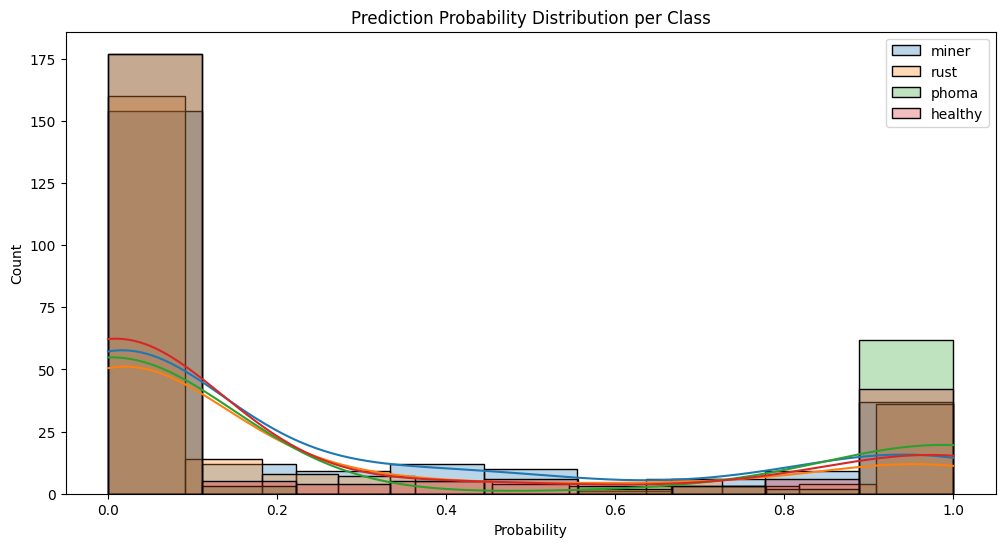


Searching for best thresholds per class...
Best Thresholds: [0.42000000000000004, 0.36000000000000004, 0.12, 0.45]
Best F1 Scores: [0.8296296296296296, 0.7966101694915254, 0.9517241379310345, 0.8717948717948718]

Test F1 Score (Micro) with optimized thresholds: 0.8660194174757282
Test F1 Score (Macro) with optimized thresholds: 0.8624397022117654

Confusion Matrices per class:

Class: miner
[[171  10]
 [ 13  56]]


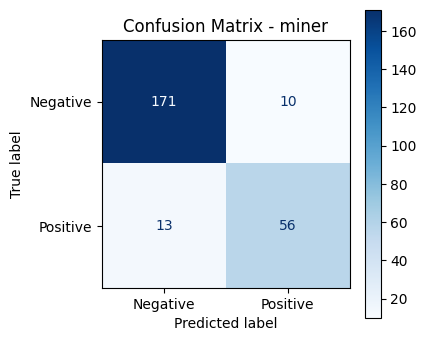


Class: rust
[[179  14]
 [ 10  47]]


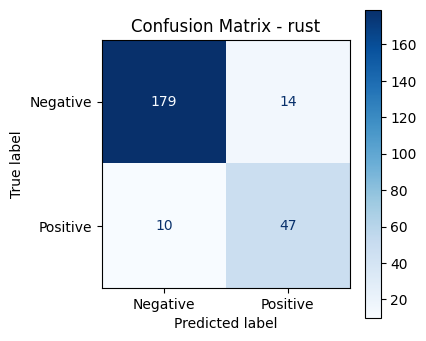


Class: phoma
[[174   3]
 [  4  69]]


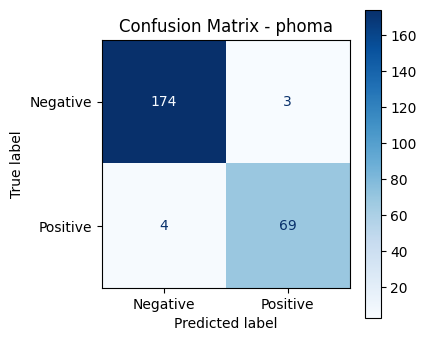


Class: healthy
[[184   6]
 [  9  51]]


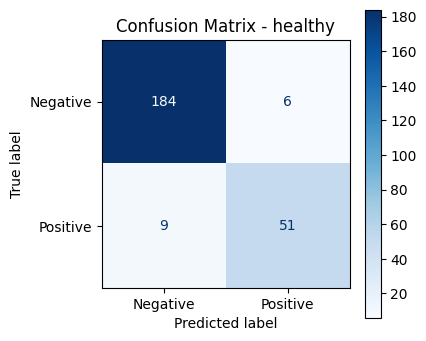

In [ ]:
# 性能評価
from sklearn.metrics import f1_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# GridSearchCVの結果から最高精度のモデルを取得
best_model = grid_result.best_estimator_
keras_model = best_model.model_

score = keras_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test binary_accuracy:', score[1])

# 予測確率の取得
y_pred_prob = keras_model.predict(X_test, verbose=0)

# 確率分布の可視化
plt.figure(figsize=(12, 6))
labels = y_test.columns if hasattr(y_test, 'columns') else [f'Class {i}' for i in range(y_test.shape[1])]
for i, label in enumerate(labels):
    sns.histplot(y_pred_prob[:, i], label=label, kde=True, alpha=0.3)
plt.title('Prediction Probability Distribution per Class')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

# 最適な閾値の探索
print("\nSearching for best thresholds per class...")
best_thresholds = []
best_f1_scores = []

# y_testがDataFrameかnumpy arrayかを確認して処理
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test

for i in range(y_test_np.shape[1]):
    best_t = 0.5
    best_f1 = 0
    # 0.01から0.50まで探索
    for t in np.arange(0.01, 0.50, 0.01):
        y_p = (y_pred_prob[:, i] > t).astype(int)
        score = f1_score(y_test_np[:, i], y_p)
        if score > best_f1:
            best_f1 = score
            best_t = t
    best_thresholds.append(best_t)
    best_f1_scores.append(best_f1)

print(f"Best Thresholds: {best_thresholds}")
print(f"Best F1 Scores: {best_f1_scores}")

# 最適な閾値で予測を決定
y_pred = np.zeros_like(y_pred_prob)
for i in range(y_pred.shape[1]):
    y_pred[:, i] = (y_pred_prob[:, i] > best_thresholds[i]).astype(int)

f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print('\nTest F1 Score (Micro) with optimized thresholds:', f1_micro)
print('Test F1 Score (Macro) with optimized thresholds:', f1_macro)

# Confusion Matrix
print("\nConfusion Matrices per class:")
cms = multilabel_confusion_matrix(y_test, y_pred)
labels = y_test.columns if hasattr(y_test, 'columns') else [f'Class {i}' for i in range(y_test.shape[1])]

for i, label in enumerate(labels):
    print(f"\nClass: {label}")
    print(cms[i])
    
    # Plotting
    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cms[i], display_labels=['Negative', 'Positive'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix - {label}')
    plt.show()